# Predicting Number of Home Burglaries in NYC Using SARIMA Model

In this project, I chose to analyze the NYC home burglaries dataset extracted from the NYPD Complaints Incident level data (https://data.cityofnewyork.us/Public-Safety/NYPD-Complaint-Data-Historic/qgea-i56i ). The dataset contains observations ranged from 1.1.2006 to 31.12.2018. Using seasonal ARIMA model, which accounts for the trend and seasonality in the data, I predict the number of home burglaries at Precinct no. 44 (New York City policing is distibuted to precincts - each precinct responsible for an area).

## Preprocessing

Let import the rlevant python libraries and the dataset. the dataset was extracted from NYPD incident level dataset where I kept only data aboot burglaries (due to long running time and limited space, I don't present that filter in code). Due to github limit on file size, I splitted the dataset to 3 parts and concatenate it in the code. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import itertools
import warnings
warnings.filterwarnings("ignore")

#Concatenate splitted files to one dataset) 
list_files = []
for i in range(3):
    df = pd.read_csv('NYPD' + str(i) + '.csv', index_col=0)
    list_files.append(df)
data_burg = pd.concat(list_files, axis=0, ignore_index=True)

Since I focus on home burglaries, I apply the following filter:
- Keep observations where the text in the 'PREM_TYP_DESC' column contains the word ‘RESIDENCE’.
- Drop observations where the “PD_DESC” column contains “Commercial” or “Truck”.

In [2]:
#filtering burglaries data
print('Type of Burglaries:\n', data_burg['PREM_TYP_DESC'].unique())
data = data_burg[data_burg['PREM_TYP_DESC'].str.contains('RESIDENCE', na=False)].reset_index(drop=True)

Type of Burglaries:
 ['RESIDENCE-HOUSE' 'RESIDENCE - APT. HOUSE' 'DRUG STORE' 'STREET'
 'SMALL MERCHANT' 'COMMERCIAL BUILDING' 'CHAIN STORE' 'OTHER' nan
 'RESIDENCE - PUBLIC HOUSING' 'GROCERY/BODEGA' 'DRY CLEANER/LAUNDRY'
 'FAST FOOD' 'CHURCH' 'BEAUTY & NAIL SALON' 'PARKING LOT/GARAGE (PRIVATE)'
 'DEPARTMENT STORE' 'CONSTRUCTION SITE' 'PRIVATE/PAROCHIAL SCHOOL'
 'CLOTHING/BOUTIQUE' 'RESTAURANT/DINER' 'GYM/FITNESS FACILITY' 'SYNAGOGUE'
 'TELECOMM. STORE' 'FOOD SUPERMARKET' 'BANK' 'STORAGE FACILITY'
 'BAR/NIGHT CLUB' 'HOTEL/MOTEL' 'FACTORY/WAREHOUSE' 'JEWELRY'
 'VARIETY STORE' 'MARINA/PIER' 'SHOE' 'STORE UNCLASSIFIED' 'GAS STATION'
 'PARK/PLAYGROUND' 'PARKING LOT/GARAGE (PUBLIC)' 'ATM' 'LIQUOR STORE'
 'CANDY STORE' 'OTHER HOUSE OF WORSHIP' 'BUS TERMINAL' 'PUBLIC BUILDING'
 'DOCTOR/DENTIST OFFICE' 'ABANDONED BUILDING' 'TRANSIT FACILITY (OTHER)'
 'PUBLIC SCHOOL' 'HOSPITAL' 'MAILBOX INSIDE' 'BOOK/CARD'
 'TRANSIT - NYC SUBWAY' 'OPEN AREAS (OPEN LOTS)' 'SOCIAL CLUB/POLICY'
 'AIRPORT TERMINAL'

In [3]:
print('More detailed description of Burglaries:\n', data_burg['PD_DESC'].unique())
data[["PD_DESC", "PD_DESC_TYPE", "PD_DESC_TM"]] = data["PD_DESC"].str.split(",", expand = True) #splitting the description column to its components
data.drop("PD_DESC", axis=1, inplace=True)
data.drop(data[data["PD_DESC_TYPE"]=='COMMERCIAL'].index, inplace=True)
data.drop(data[data["PD_DESC_TYPE"]=='TRUCK NIGHT'].index, inplace=True)
data.drop(data[data["PD_DESC_TYPE"]=='TRUCK DAY'].index, inplace=True)

More detailed description of Burglaries:
 ['BURGLARY,RESIDENCE,DAY' 'BURGLARY,COMMERCIAL,NIGHT' 'BURGLARY,TRUCK DAY'
 'BURGLARY,RESIDENCE,NIGHT' 'BURGLARY,COMMERCIAL,DAY'
 'BURGLARY,UNCLASSIFIED,DAY' 'BURGLARY,UNCLASSIFIED,NIGHT'
 'BURGLARY,TRUCK NIGHT' 'BURGLARY,RESIDENCE,UNKNOWN TIM'
 'BURGLARY,COMMERCIAL,UNKNOWN TI' 'BURGLARY,UNKNOWN TIME'
 'BURGLARY,UNCLASSIFIED,UNKNOWN']


I also preprocessed the date values which will be used later for the time series analysis:
- I used the column 'CMPLNT_FR_DT' (which is the exact time or the beginning of the incident time range) as the base for the date column 
- In case of Nan values, I use the 'CMPLNT_TO_DT' ((which is the ending of the incident time range) values as the incident date.
- Looking on the data, there is many typing errors in the year of the event. I identify such errors where the month value of 'CMPLNT_FR_DT' equals the month value of 'CMPLNT_TO_DT' but the year is different. In that case, I set the date value to be equal to 'CMPLNT_TO_DT' value.

In [4]:
#Preprocessing time data
data.loc[155601,'CMPLNT_FR_DT']=data.loc[155601,'CMPLNT_TO_DT'] #updating date with year value of 1017 to 2017.
data['CMPLNT_FR_DT'] = pd.to_datetime(data['CMPLNT_FR_DT']) #changing date values to datetime dtype
data['CMPLNT_TO_DT'] = pd.to_datetime(data['CMPLNT_TO_DT'])
data.insert(loc=1, column ='date', value = data['CMPLNT_FR_DT']) #create the main date column
data['date'].fillna(data['CMPLNT_TO_DT'], inplace=True)

#handling dates with typo year value
print('examples for year typo errors:\n', data[['CMPLNT_FR_DT', 'CMPLNT_TO_DT']].tail(n=30).head(5))
cond = (data['CMPLNT_FR_DT'].dt.month == data['CMPLNT_TO_DT'].dt.month) & (data['CMPLNT_FR_DT'].dt.year != data['CMPLNT_TO_DT'].dt.year)
data['date'] = np.where(cond, data['CMPLNT_TO_DT'], data['date'])

examples for year typo errors:
        CMPLNT_FR_DT CMPLNT_TO_DT
155590   2000-04-30   2007-04-30
155591   2000-04-03   2007-04-03
155592   2000-02-23   2006-02-23
155593   2000-02-18   2006-02-19
155594   2000-01-17   2007-01-18


Next, I extract useful features for the time series analysis and filter the dataset for observations collected from 2006 (there are few observations from the end of 2005).

In [6]:
#datetime feature extraction
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day
data['day_of_week']=data['date'].dt.dayofweek
data['week'] = data['date'].dt.week 
data['date_YM'] = data['date'].apply(lambda dt: dt.replace(day=1))

#filtering for dates on and after 1.1.2006
data=data[data['year']>=2006]

## Data Visualization

Let take a look on time trends. I Define a function that will be useful for visualization.

In [7]:
def plots(data, timeframe, title, kind, color):
    """The function get as input dataframe, timeframe for plotting and plot attributes
    and output the plot"""       
    title='NYC total home burglaries' + title
    fig=data.groupby(timeframe)['day'].count().plot(kind=kind, title=title, color=color)
    fig.xaxis.set_label_text("")
    fig.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

Plotting the total home burglaries by year show that From 2006 to 2018 we can see clear decreasing trend in reported home burglaries with the exception of 2011-2012 where the number has increased.

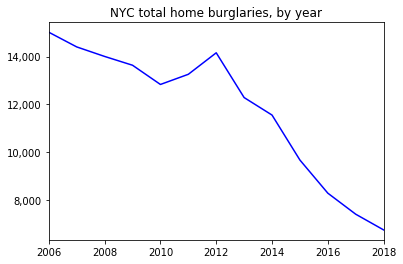

In [8]:
plots(data, 'year', ', by year', 'line', 'b') #plot by year

Monthly-wise, we can see that the number of burglaries is lower in February-April, more colder months with less daylight hours. Nevertheless, December-January numbers are higher, maybe due to the holiday season when people spent out of home - looking at daily data, shows that the 4-5 days before charismas and the day before New Year’s Day (all in December) are more prone to burglaries. 

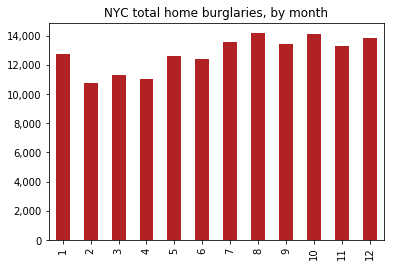

In [9]:
plots(data, 'month', ', by month', 'bar', 'firebrick') #plot by month

Additionally, the number of burglaries in weekends (Friday and Saturday which represented by the digits 5 and 6, respectively) are much lower compared to work days. 
The common to all findings is that burglars wait for people not being at home (work, vacation, longer hours out of home when daylight hours are longer).

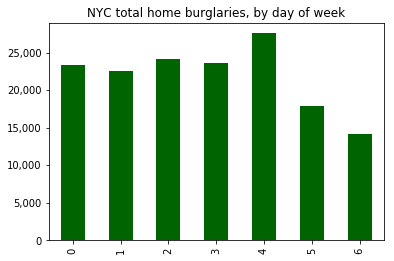

In [10]:
plots(data, 'day_of_week', ', by day of week', 'bar', 'darkgreen') #plot by day of week     

Looking on the data by borough reveals that the trend until 2014 was not exactly identical across bourough.
While the number of home burglaries in Brooklyn, Manhattan and Queens was declining since 2007-2018, in Bronx (where precinct 44 belongs) it was stagnant until 2012 and in Staten Island it was increasing until 2014. Since 2014, we see significant decline in home burglaries in all areas (In Manhattan the decline is more modest). The changes are not correlated with different trends in demographics as the city population has increased by only ~2.7% between 2010 census and 2018 census where the Bronx saw the largest increase of 3.4% according to the Department of City Planning website. 

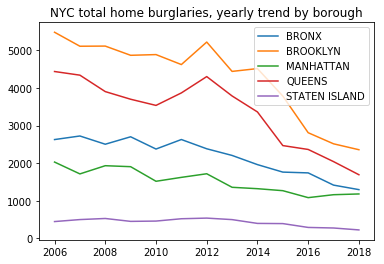

In [11]:
year_bor=data.groupby(['year','BORO_NM']).count()['day'].unstack()
plt.plot(year_bor)
plt.title('NYC total home burglaries, yearly trend by borough')
plt.legend(year_bor.columns, loc='best')

Taking a deeper dive into Bronx’ precincts level, we see that in the recent years most precincts in Bronx saw sharp decrease in home burglaries compared to the beginning of the period excluding precincts 40 and 47 which doesn’t show consistent pattern of decrease in number of burglaries. 
Interestingly, when looking on the correlations of home burglaries in precinct 44 with other precincts in Bronx, it is a bit surprising to see that there is weaker correlation with neighboring precincts - 40,42,46,48. (see map and table below). The finding could be random or maybe there is be some reason (like increased incidents in one month cause increased police presence and burglars move to neighbor precinct). 

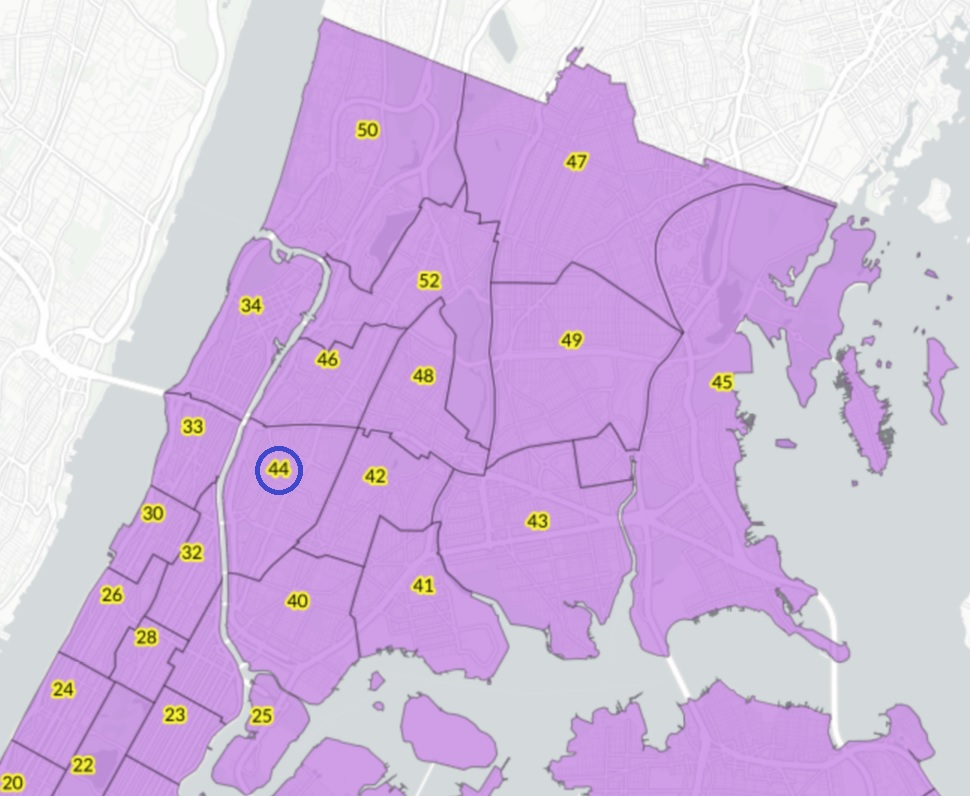

In [12]:
from IPython.display import display, Image
display(Image(filename='precinct_map.png'))

In [13]:
#data of precincts in The Bronx borough
data_brnx = data[data['BORO_NM']=='BRONX']
year_prec=data_brnx.groupby(['year','ADDR_PCT_CD']).count().unstack()['day'].iloc[:,:-1]
chng_rate=(year_prec/year_prec.iloc[0]-1).round(2)
print('Cumulative change rate in the number of home burglaries by precincts:\n', chng_rate)

Cumulative change rate in the number of home burglaries by precincts:
 ADDR_PCT_CD  40.0  41.0  42.0  43.0  44.0  45.0  46.0  47.0  48.0  49.0  50.0  \
year                                                                            
2006         0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
2007         0.00  0.35 -0.02 -0.06  0.17 -0.10 -0.09  0.07  0.08  0.00  0.34   
2008        -0.03  0.23 -0.41 -0.04 -0.09 -0.11 -0.19  0.15  0.01 -0.13  0.46   
2009         0.13  0.76 -0.43  0.03  0.08  0.12 -0.33  0.18  0.04  0.02  0.33   
2010         0.03  0.36 -0.45 -0.07 -0.05  0.09 -0.39  0.07 -0.17 -0.16  0.10   
2011         0.05  0.67 -0.37 -0.08  0.19  0.10 -0.29  0.37 -0.29 -0.01  0.43   
2012        -0.31  0.75 -0.45 -0.11  0.08 -0.25 -0.36  0.25 -0.21 -0.08  0.29   
2013        -0.06  0.59 -0.34 -0.06 -0.12 -0.38 -0.45  0.31 -0.17 -0.34  0.06   
2014        -0.38  0.43 -0.54 -0.15 -0.15 -0.45 -0.48  0.11 -0.06 -0.55  0.06   
2015         0.06 -0.13 -0.51 -0.25 -0

In [14]:
monthly_prec=data_brnx.groupby(['date_YM','ADDR_PCT_CD']).count()['day'].unstack().iloc[:,:-1]
corr = monthly_prec.corr().iloc[4,:]
print('Correlation of monthly home burglaries in precinct 44 with other precincts in Bronx:\n', corr.round(2))

Correlation of monthly home burglaries in precinct 44 with other precincts in Bronx:
 ADDR_PCT_CD
40.0    0.18
41.0    0.41
42.0    0.16
43.0    0.49
44.0    1.00
45.0    0.47
46.0    0.39
47.0    0.31
48.0    0.34
49.0    0.54
50.0    0.41
52.0    0.51
Name: 44.0, dtype: float64


At last, we plot the monthly series of precinct 44 to see the trend in the district. The plot commensurate with my previous findings -
 - Trend: Significant decrease in recent years in the number of home burglaries but like we saw in overall Bronx data – There was stagnation until 2012-2013. 
 - Seasonality: decrease in winter months and increase in summer and in the December (holidays).

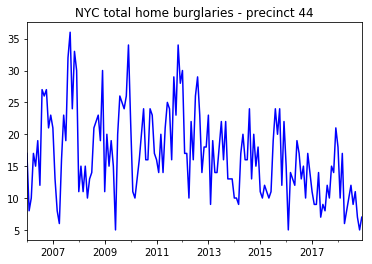

In [15]:
data_44=data[data['ADDR_PCT_CD']==44]
plots(data_44, 'date_YM', ' - precinct 44', 'line', 'b') #plot precinct 44 monthly home burglaries

## Seasonal ARIMA Model

Looking on the precinct 44 time series decomposition to its trend, seasonal and residuals show clearly the trend and seasonality in the data (see graph below). Autocorrelation in residuals may exist as the number of burglaries in one period could affect the number in the following month (due to daylight hours, police presence for example).

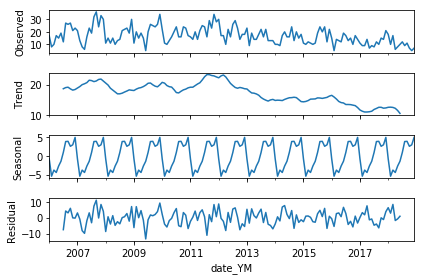

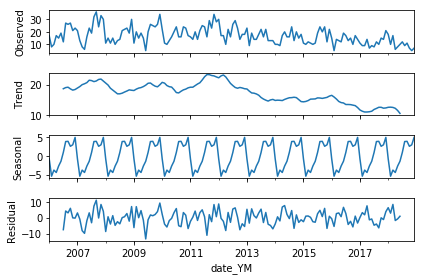

In [16]:
monthly_44=data_44.groupby('date_YM')['day'].count() #monthly data time series
sm.tsa.seasonal_decompose(monthly_44).plot() #decomposition plot

Looking on the residuals and Using Dickey–Fuller test show that the precinct 44 home burglaries monthly series is not stationary. The Dickey–Fuller test present p-value of 0.82 – clearly way above the 5% threshold which below it we can reject the null hypothesis and say the data is stationary.

In [17]:
#Dickey–Fuller test for stationary
from statsmodels.tsa.stattools import adfuller 
dftest = adfuller(monthly_44, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Test Statistic                  -0.767657
p-value                          0.828438
#Lags Used                      11.000000
Number of Observations Used    144.000000
Critical Value (1%)             -3.476598
Critical Value (5%)             -2.881829
Critical Value (10%)            -2.577589
dtype: float64


Nevertheless, differentiating the series make it stationary, supported by Dickey–Fuller test for the differentiated series. Now the P-value is close to 0. 

In [18]:
monthly_44_diff = monthly_44 - monthly_44.shift(1)
monthly_44_diff.dropna(inplace = True) 
dftest = adfuller(monthly_44_diff, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Test Statistic                -7.930609e+00
p-value                        3.521452e-12
#Lags Used                     1.000000e+01
Number of Observations Used    1.440000e+02
Critical Value (1%)           -3.476598e+00
Critical Value (5%)           -2.881829e+00
Critical Value (10%)          -2.577589e+00
dtype: float64


Seasonal ARIMA model fits the data structure as it aims to capture data that may contain trend and seasonal components and autocorrelation in the data as well. Since with SARIMA the model is differentiated, the series would be stationary as I showed before. The Seasonal ARIMA model’s hyperparameters are represented by (p,d,q)x(P,D,Q)m. The first 3 parameters indicating the orders of the autoregressive model (p - number of time lags of previous values), the differencing (d - number of times the data have had past values subtracted) and the moving average model (q - number of time lags of forecast errors); and another similar 3 parameters but for the seasonal component (using lags and differentiating of previous season value). I define the number of periods in each season, m, to be 12 as I consider seasonality according to month of year.

Before fitting the model I divide the data into train and validation set. I use the 2018 data as the validation set. I Keep December 2018 in my validation set but I note that data point looks suspiciously really low compared to previous Decembers and the trend we have seen in the data. The last reported data in December is 17.1.2018 and it possible that the December 18’ data is not complete for precinct 44.

In [19]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

#splitting hte model to training and validation set
Train=pd.DataFrame(monthly_44.loc['2006-01-01':'2017-12-01'])
valid=pd.DataFrame(monthly_44.loc['2018-01-01':'2018-12-01'])

I use grid search in order to determine the model’s beat hyperparameters. I use as a deeciding criteria the AIC value of the model (Akaike information criterion) which estimates the relative amount of information lost by a given model. Than I use the best combination which minimizes the AIC value. I get the result of (2,1,2)X(0,2,2)12 as the model best hyperparameters. It should be noted that running time could be 10-15 minutes.

In [20]:
#evaluating the model 
def sarima (Train): 
    """The function get as input univariate time series model and returns the
    best set of hyperparameters for sesonal arima model using AIC as 
    deciding criteria and the best_model fitted with those hyperparameters"""   
    warnings.filterwarnings("ignore")
    p = d = q = range(0, 3)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]   
    #intitalizing parameters
    best_aic = 10000.0 
    best_param = ((1,0,0), (0,0,0,12))
    #best_model = sm.tsa.statespace.SARIMAX(Train.day).fit()
    best_model = SARIMAX(Train.day).fit()
    #preforming grid search
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                model = SARIMAX(Train.day, order=param, seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False).fit()
                if model.aic < best_aic:
                    best_aic = model.aic
                    best_param = (param, param_seasonal)
                    best_model = model
            except: 
                continue
    return best_model, best_param

model, param  = sarima(Train)
print('best SARIMA hyper parameters are', param)

best SARIMA hyper parameters are ((2, 1, 2), (0, 2, 2, 12))


I test the model on the validation set using root mean squared error and plotting the model predictions against the actual values in the validation set.

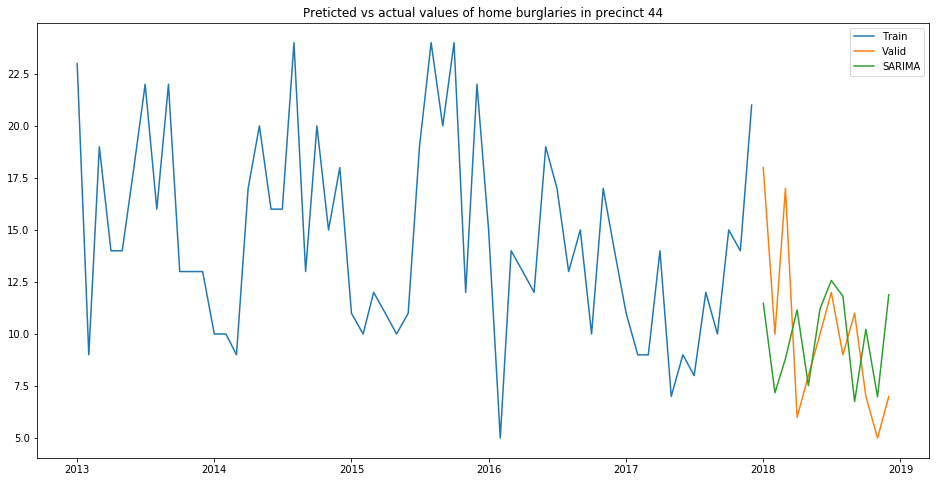

In [21]:
pred = model.predict(start="2018-01-01", end="2018-12-01", dynamic=True)
plt.figure(figsize=(16,8)) 
plt.plot(Train['day'][-60:], label='Train') 
plt.plot(valid['day'], label='Valid') 
plt.plot(pred, label='SARIMA') 
plt.legend(loc='best') 
plt.title('Preticted vs actual values of home burglaries in precinct 44')
plt.show()

In [22]:
#model error
from sklearn.metrics import mean_squared_error 
from math import sqrt 
rms = sqrt(mean_squared_error(valid.day, pred)) 
print(rms)

4.185182835274802


We can see that the model is doing a good job to capture the overall declining trend and the seasonality identified in the training set - the model predicted low values in the first months of the year (especially February) and large values in the summer months and in December. The mean squared error is 4.2.
The predicted values in Q4 2018 was higher compared with the actual values in Q4 2018. The actual values in the quarter was uniquely low compared to previous quarters and previous seasons, what the model could not capture using the training set. The model also predicted 29 burglaries in Q1 2018, lower than the actual value of 45 in 2018. In fact, The model predicted for January 2018 the same value as the number of home burglaries in Q1 2017 balancing the declining trend the model sees with the high value of 50 burglaries in Q4 2017. 

In [23]:
#train again the model on the whole dataset and predict the number of home burglaries in Q1 2019
Train=pd.DataFrame(monthly_44.loc['2006-01-01':'2018-12-01'])
selected_model = SARIMAX(Train.day, order=param[0],seasonal_order=param[1], enforce_stationarity=False, enforce_invertibility=False).fit() 
pred = selected_model.predict(start="2019-01-01", end="2019-03-01", dynamic=True)
print(pred.round(1))

2019-01-01    10.1
2019-02-01     3.3
2019-03-01    10.4
Freq: MS, dtype: float64


In order to predict the number of home burglaries in the first 3 months of 2019 I train again the model with the new information of the 2018 observations. The model predicts ~24 burglaries in in the first quarter of 2019 - 10.1 in January, 3.3 in February and 10.4 in March. The low prediction compared to previous seasons (45 burglaries in Q1 2018, 29 burglaries in Q1 2019) is affected by the low value of 19 home burglaries in Q4 2018. The Intra month volatility is similar, acoording to expectations. 

## Summary 

In this project I used Seasonal ARIMA to model univariate time series of home burglaries in NYC. For future work, an improvement to my model could be as the following:
- Finding and using exogenous variables to the time series – population size variable, socio-economic indicators (like unemployment rate, poverty rate in the neighborhood) or data on police activities (number of policemen in precincts, precinct budget).
- Another area for further analysis is the frequency of data I used. For simplicity, I chose to work with monthly time series as using season time period of 365 days in the SARIMA model is (1) very expensive computationally and (2) we need also to handle the week and holidays seasonality in addition to the month seasonality. Nevertheless, working with daily data could add more information to the model.
- Additionally, there could be limitation of the police incident data as it could suffer from selection bias. Meaning, it could be that the number of reports to the police are dependent on the trust of the local residents in the police. Data of places with low trust in police could be biased downward so they look safer in the data.
